# Step 0: Importing Relevant Packages (0%)

In [74]:
# Web Scraping Libraries
from bs4 import BeautifulSoup  # for scraping
import requests  # for sending HTTP requests
# Data Processing Libraries
import csv
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import pearsonr
from matplotlib_venn import venn3

# Step 1: Crawl a Real World Data Set (2%)

In [2]:
# Covid Data
url = "https://www.worldometers.info/coronavirus/#main_table"  # Web address of data
response = requests.get(url)  # Performing a get request for the data at the url location
soup_object = BeautifulSoup(response.content)  # Parsing the request response to create a soup_object that can be searched for a table
covid_table = soup_object.find("table")  # Searching the soup_object for a table

with open("Live_Covid_Data.csv", "w", newline="") as csv_file:  # Opening a CSV file to be written into
    writer = csv.writer(csv_file)  # Defining the writer as a csv writer that writes to the opened file

    for row in covid_table.find_all("tr"):  # Iterate through the rows of the table, "tr" points to a row in the table
        cells = row.find_all("td")  # Get the cells in the row, "td" points to a cell in the row

        if cells:  # If there are cells...
            values = [cell.text for cell in cells]  # Values is a list of values for each cell in the row of cells
            writer.writerow(values)  # Write the values to the CSV


## Where does the data come from?
This data comes from a website called Worldometer. Worldometer is an independant, self-financed, and published by a small digital media to ensure that there is no political, governmental, or corporate affiliation. Their global Covid-19 statistics are used by the UK government, Financial Times, The New York Times, Business Insider, and BBC with many more financial, technological, and academic institutions over the last 15 years. The data is collected from a range of sources: official reports (from government communication channels) and local media sources; a team of analysts and researchers validate the data from this list of over 5,000 sources. Later on more data is scraped from wikipedia, but the original source of the data is the UN.

## What are the variables of interest?
The data has many interesting variables, but the large majority of them can be derived from these few: total cases, total deaths, total recovered, total tests, population, and the continent of each country/territory. From these we can create many interesting relationships to test some hypotheses. There are a few other variables that would be of interest, these are: new cases, new deaths, new recovered, and active cases. The reason that the "new" variables are not of interest is that the data set does not well define what "new" means and there seems to be a fair bit of missing data from various countries. This is the same reason that active cases is not of much interest, Covid may still be around but people don't treat it as such. Tests are no longer free so people no longer test themselves, and even if people did test themselves many would forget to/not bother with registering their positive results with the NHS or other healthcare services -> this data is not representative of the truth.

## How was the data scraped/collected?
The Covid data was scraped using the requests and BeautifulSoup packages. The response from the url request was turned into content and parsed in the BeautifulSoup function to produce a soup object that could be searched and written to a CSV file. The find() function is then used to search for the first occurance of a specified tag, in this case "table", within the soup_object and saves it as the covid_table. A CSV file is then opened in "write" mode which then gets the covid table written to it, by iterating through each cell of each row until it is complete. When complete, the csv file is saved and closed to the path specified in the open() function.


# Step 2: Data Preparation and Cleaning (5%)

In [36]:
# Creating list of column names
col_names = ["Country", "Total Cases", "New Cases", "Total Deaths", "New Deaths", "Total Recovered", "New Recovered", "Active Cases", "Critical Cases",
             "Total Cases / 1M People", "Total Deaths / 1M People", "Total Tests", "Total Tests / 1M People", "Population", "Continent", "One Case / n People",
             "One Death / n People", "One Test / n People", "New Cases / 1M People", "New Deaths / 1M People", "Active Cases / 1M People"]

# Reading the csv to a dataframe with the column names specified, encoding with "latin-1" to get around "utf-8" decoding issue.
df = pd.read_csv("Live_Covid_Data.csv", names=col_names, header=None, encoding="latin-1")

# Tidying up the names of the continent by removing the "\n"'s on it, i.e. "\nNorth America\n"
old_continent_list = df.iloc[0:7]["Country"].tolist()  # Locating the continent names and putting them into a list
new_continent_list = []  # Defining a list for the formatted continent names

for old_continent in old_continent_list:  # Iterate through current continent names
     new_continent = "Antarctica" if old_continent == "\n\n" else old_continent.replace("\n", "")  # Removing \n from continent names/identifying Antarctica
     if new_continent == "Oceania":  # In "Continent" column countries are assigned Australia/Oceania not just Oceania
         new_continent = "Australia/Oceania"  # Renaming continent
     new_continent_list.append(new_continent)  # Addding the renamed continenet to the new list

# Changing the index to the name of the Country/Continent
df.set_index("Country", inplace=True)  # inplace=True updates the original datafram immediately

# Changing the index name to the re-formatted continents. set_value has been depricated, also before setting the index as Country the continent rows had
# an index of NaN so at[row, col] couldn't be used to assign values either. Therefore, application of the reformatted names had to after set_index was done.
n = 0
for new_continent in new_continent_list:  # Iterate through the new continent names
    df.rename(index={old_continent_list[n]: new_continent}, inplace=True)  # Replace the old continent name with corresponding new continent name
    n += 1

# Moving country continent and population to first/second column as it is important for comparison to total cases etc
pop_col = df.pop("Continent")
df.insert(0, "Continent", pop_col)
pop_col = df.pop("Population")  # Removes the column from DF while saving it to a variable
df.insert(1, "Population", pop_col)  # Replacing the column in first position using previously assigned variable
pop_col = df.pop("Total Tests")
df.insert(5, "Total Tests", pop_col)

# Removing non-ccountries/non-territories from the DF
drop_list = ["Diamond Princess", "MS Zaandam", "Total:"]  # List of unwanted non-countries/non-territories
for item in drop_list:  # Iterate through list
    df.drop(index=item, axis=0, inplace=True)  # Permanently delete the corresponding row in place

# Calculating the population of each continent and the world
global_population = 0  # Defining global population as 0
for continent in new_continent_list:  # iterate through the continents
    # If a row has continent "continent" and is not the row for the continent itself, population is added to the corresponding list
    population_list = df.loc[(df["Continent"] == continent) & (df.index != continent), "Population"].tolist()
    continent_population = 0  # Defining the continent's population as 0

    for population in population_list:  # Iterate through all populations in the list
        new_population = re.sub(",", "", population)  # Removing the commas from the strings seperating 1000's
        continent_population += int(new_population)  # Adding the population to the continent populatuon

    global_population += continent_population  # Adding the continent population to the global population
    df.at[continent, "Population"] = continent_population  # Replacing the continents NaN population with the calculated population
df.at["World", "Population"] = global_population  # Replacing the world's NaN population with the calculated population

# Dropping Antarctica as its data is not useful
df.drop(index="Antarctica", axis=0, inplace=True)

# Handling missing values
df = df.replace(r"^\s*$", np.nan, regex=True)
df

# Remove commas from all columns and convert all columns to floats while avoiding non-numeric data
df = df.replace(",", "", regex=True)  # Removing commas from entire dataframe, regex=True automates searching and replacing
df
for column in df:  # Iterate through all columns in the dataframe
    try:  # Try the following experssion:
        df[column] = df[column].astype(float)  # Convert the column to floats
    except ValueError:  # If this error is caused, raise an exception for the Nan/string value
        pass  # Skip the conversion if the column contains non-numeric data

# Dropping columns with the format "New..." as "New" is ambiguous and not described on the website, they also contain a lot of NaN.
for column in df:
    if "New" in column:
        df.drop(columns=column, inplace=True)

# Calculating the total tests taken in each continent
global_total_tests = 0  # Defining the global total as 0
for continent in new_continent_list[:-1]:  # Iterating through continents, except antarctica
    continent_total_tests = 0  # Defining the continent total as 0
    test_list = df.loc[(df["Continent"] == continent) & (df.index != continent), "Total Tests"].tolist()  # Adding all test numbers to a list
    clean_test_list = [x for x in test_list if (math.isnan(x) == False)]  # Removing nan values from the list
    continent_total_tests = sum(clean_test_list)  # Summing all the values in the list
    global_total_tests += continent_total_tests  # Adding the continent total to the global total
    df.at[continent, "Total Tests"] = continent_total_tests  # Reassigning the continent total tests value to new calculated value
df.at["World", "Total Tests"] = global_total_tests  # Reassign global test total after for loop has completed
df
# Recalculating X/1M based on the live data from other columns where x = Total Cases, Total Deaths, Total Tests, Active Cases
for column in df:  # Iterate through columns in the DF
    if "1M People" in column:  # Checking if the column is a target for recalculation
        reduced_column = column.replace(" / 1M People", "")  # Formulating the column from which x/1M column will be calculated
        df[column] = (df[reduced_column] / df["Population"]) * 1000000  # Recalculating column

# Recalculating how many people there where per one case/death/test
df["One Case / n People"] = df["Population"] / df["Total Cases"]
df["One Death / n People"] = df["Population"] / df["Total Deaths"]
df["One Test / n People"] = df["Population"] / df["Total Tests"]
df["Total Recovered / 1M People"] = df["Total Recovered"] / df["Population"] * 1000000

df.loc["USA":]

,Continent,Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People,Total Recovered / 1M People
Country,,,,,,,,,,,,,,,,
USA,North America,3.348053e+08,103086927.0,1121097.0,1.155456e+09,99979336.0,1986494.0,4994.0,307901.148951,3348.504650,3.451129e+06,3.247796,298.640768,0.289760,5933.281773,298619.362529
India,Asia,1.406632e+09,44681170.0,530721.0,9.119512e+08,44147002.0,3447.0,698.0,31764.652813,377.299169,6.483226e+05,31.481534,2650.416652,1.542442,2.450535,31384.903109
France,Europe,6.558452e+07,39407727.0,162643.0,2.714902e+08,38737262.0,507822.0,869.0,600869.354563,2479.899296,4.139547e+06,1.664255,403.242181,0.241572,7743.016423,590646.438844
Germany,Europe,8.388360e+07,37509539.0,162688.0,1.223324e+08,36861300.0,485551.0,1406.0,447161.790727,1939.449520,1.458359e+06,2.236327,515.610223,0.685702,5788.390378,439433.950829
Brazil,South America,2.153536e+08,36504006.0,694909.0,6.377617e+07,35247755.0,561342.0,8318.0,169507.299560,3226.827982,2.961463e+05,5.899451,309.901862,3.376710,2606.606150,163673.865427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Niue,Australia/Oceania,1.622000e+03,644.0,NaN,NaN,495.0,149.0,NaN,397040.690506,NaN,NaN,2.518634,NaN,NaN,91861.898890,305178.791615
Vatican City,Europe,7.990000e+02,29.0,NaN,NaN,29.0,0.0,NaN,36295.369212,NaN,NaN,27.551724,NaN,NaN,0.000000,36295.369212
Western Sahara,Africa,6.261610e+05,10.0,1.0,NaN,9.0,0.0,NaN,15.970334,1.597033,NaN,62616.100000,626161.000000,NaN,0.000000,14.373300


## Steps to prepare and clean Covid data
Firstly I created a list of column names to be used when reading the CSV to a pandas DataFrame. When the CSV file had been written into the DataFrame, the names of all the continents were in an odd format, "\nNAME\n", and in the case of what I assumed to be antarctica "\n\n". I added these names to a list and created an empty list for the reformatted names to be added to, this list was then iterated through to remove any "\n" from the name and, in the case of Antarctica, simply replace the name entirely and add it to the new list. The index was then set to "Country" and the names were replaced using the list created. A few columns were then popped and replaced in a more appropriate order. Following this, some none countries were removed from the DataFrame, two cruise ships (they were in the news a lot as covid began) and a bunch of summary rows that had read into the CV/DataFrame incorrectly. The continent rows had little data, so i created it from the other countries in the list. I iterated through the new continent list and, if a row contained the current continent being searched for, the population was added to the continent population list which was then added to the global list at the end of the iteration process. To make this work, the numbers in all the columns had to be changed from the from "1,234,567,89" of string type to "1234567.89" of float type. The previouslt mentione "new" columns then got dropped as their data is not consistantly available for enough countries to make them useful.

## Steps to extract new features from Covid Data.
There were already a lot of very interesting features created from the main data in the data set, but a lot of the numbers didn't quite add up. I recalculated all of the "One X / n People" columns for this very reason. I also created a "Total Recovered / 1M People" column for the comparison to the other "X / 1M People" columns.

In [37]:
# Adding Wikipedia GDP Data to DF
wiki_url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)"  # Web address of data
wiki_response = requests.get(wiki_url)  # Performing a get request for the data at the url location
wiki_soup = BeautifulSoup(wiki_response.text, "lxml")  # Parsing the request response to create a soup_object that can be searched for a table
wiki_table = wiki_soup.find("table", {"class": "wikitable"})  # Searching the soup object for a table of specifc class


rows = wiki_table.find_all("tr")  # Find all the rows in the table
wiki_data = []  # Create an empty list to store the data

for row in rows:  # Iterate through the rows of the table, "tr" points to a row in the table
    cells = row.find_all("td")  # Get the cells in the row, "td" points to a cell in the row
    row_data = []  # Create an empty list to store the row data
    for cell in cells:  # Iterate through all cells in the current row
        row_data.append(cell.text)  # Append the cell data to the row data list
    wiki_data.append(row_data)  # Append the row to the table data list

wiki_df = pd.DataFrame(wiki_data)  # Convert the list to a df
wiki_col_names = ["Country", "UN Region", "IMF GDP Estimate", "Year", "World Bank GDP Estimate", "Year", "UN GDP Estimate", "Year"]
wiki_df.columns = wiki_col_names  # Renaming the columns

wiki_df = wiki_df.iloc[3:]  # Removing the top three rows as they contained unecessary data
wiki_df.set_index("Country", inplace=True)

new_wiki_df_index_list = ['USA', 'China', 'Japan', 'Germany', 'India', 'UK', 'France', 'Canada', 'Russia', 'Italy', 'Iran', 'Brazil', 'S. Korea', 'Australia', 'Mexico', 'Spain', 'Indonesia', 'Saudi Arabia', 'Netherlands', 'Turkey', 'Taiwan', 'Switzerland', 'Poland', 'Argentina', 'Sweden', 'Belgium', 'Thailand', 'Israel', 'Ireland', 'Norway', 'Nigeria', 'UAE', 'Egypt', 'Austria', 'Bangladesh', 'Malaysia', 'Singapore', 'Vietnam', 'South Africa', 'Philippines', 'Denmark', 'Pakistan', 'Hong Kong', 'Colombia', 'Chile', 'Romania', 'Czechia', 'Iraq', 'Finland', 'Portugal', 'New Zealand', 'Peru', 'Kazakhstan', 'Greece', 'Qatar', 'Ukraine', 'Algeria', 'Hungary', 'Kuwait', 'Morocco', 'Angola', 'Puerto Rico', 'Ecuador', 'Kenya', 'Slovakia', 'Dominican Republic', 'Ethiopia', 'Oman', 'Cuba', 'Guatemala', 'Bulgaria', 'Luxembourg', 'Venezuela', 'Belarus', 'Uzbekistan', 'Tanzania', 'Ghana', 'Turkmenistan', 'Sri Lanka', 'Uruguay', 'Panama', 'Azerbaijan', 'Croatia', 'Ivory Coast', 'Costa Rica', 'Lithuania', 'DRC', 'Serbia', 'Slovenia', 'Myanmar', 'Uganda', 'Jordan', 'Tunisia', 'Cameroon', 'Bahrain', 'Bolivia', 'Sudan', 'Paraguay', 'Libya', 'Latvia', 'Estonia', 'Nepal', 'Zimbabwe', 'El Salvador', 'Papua New Guinea', 'Honduras', 'Trinidad and Tobago', 'Cambodia', 'Iceland', 'Yemen', 'Senegal', 'Zambia', 'Cyprus', 'Georgia', 'Bosnia and Herzegovina', 'Macao', 'Gabon', 'Haiti', 'Afghanistan', 'Guinea', 'Palestine', 'Brunei', 'Mali', 'Burkina Faso', 'Albania', 'Lebanon', 'Botswana', 'Mozambique', 'Armenia', 'Benin', 'Malta', 'Equatorial Guinea', 'Laos', 'Jamaica', 'North Korea', 'Mongolia', 'Nicaragua', 'Syria', 'Madagascar', 'Guyana', 'Niger', 'Congo', 'North Macedonia', 'Moldova', 'Chad', 'Bahamas', 'Namibia', 'Rwanda', 'Malawi', 'Mauritius', 'Mauritania', 'Tajikistan', 'Kyrgyzstan', 'New Caledonia', 'Kosovo', 'Somalia', 'Togo', 'Bermuda', 'Liechtenstein', 'Monaco', 'Cayman Islands', 'Montenegro', 'Maldives', 'Guam', 'Barbados', 'French Polynesia', 'Fiji', 'South Sudan', 'Eswatini', 'Sierra Leone', 'Liberia', 'Djibouti', 'Burundi', 'Aruba', 'Andorra', 'Greenland', 'Suriname', 'Bhutan', 'Belize', 'Lesotho', 'Curaçao', 'CAR', 'Timor-Leste', 'Eritrea', 'Gambia', 'Cabo Verde', 'Seychelles', 'Saint Lucia', 'Zanzibar', 'Antigua and Barbuda', 'Guinea-Bissau', 'San Marino', 'Solomon Islands', 'British Virgin Islands', 'Comoros', 'Grenada', 'Northern Mariana Islands', 'Saint Kitts and Nevis', 'Vanuatu', 'Saint Vincent and the Grenadines', 'Turks and Caicos', 'Sint Maarten', 'Samoa', 'American Samoa', 'Dominica', 'São Tomé and Príncipe', 'Tonga', 'Micronesia', 'Cook Islands', 'Marshall Islands', 'Anguilla', 'Palau', 'Kiribati', 'Nauru', 'Montserrat', 'Tuvalu']

wiki_df.index = new_wiki_df_index_list
wik_df = wiki_df.replace(",", "", regex=True, inplace=True)  # Removing commas from entire dataframe, regex=True automates searching and replacing
for column in wiki_df:  # Iterate through all columns in the dataframe
    try:  # Try the following experssion:
        wiki_df[column] = wiki_df[column].astype(float)  # Convert the column to floats
    except ValueError:  # If this error is caused, raise an exception for the Nan/string value
        pass  # Skip the conversion if the column contains non-numeric data

for country in new_wiki_df_index_list:  # Iterate through all countries in the list
    value = wiki_df.loc[country, "UN GDP Estimate"]  # Take the UN GDP estimate for that ccountry
    numeric_value = pd.to_numeric(value, errors="coerce")  # Convert the value to numeric
    if pd.isnull(numeric_value):  # If the value is not numeric
        wiki_df.at[country, "UN GDP Estimate"] = np.nan  # set its value to NaN
wiki_df = wiki_df.replace("2020\n", np.nan)

df["GDP (USD million)"] = wiki_df["UN GDP Estimate"]

global_GDP = 0  # Defining the global GDP as 0
for continent in new_continent_list[:-1]:  # Iterating through continents, except antarctica
    continent_GDP = 0  # Defining the continent GDP as 0
    GDP_list = df.loc[(df["Continent"] == continent) & (df.index != continent), "GDP (USD million)"].tolist()  # Adding all GDPs to a list
    clean_GDP_list = [float(x) for x in GDP_list if (math.isnan(float(x)) == False)]  # Removing nan values from the list
    continent_GDP = sum(clean_GDP_list)  # Summing all the values in the list
    global_GDP += continent_GDP  # Adding the continent GDP to the global GDP
    df.at[continent, "GDP (USD million)"] = continent_GDP  # Reassigning the continent GDP value to new calculated value
df.at["World", "GDP (USD million)"] = global_GDP

pop_col = df.pop("GDP (USD million)")
df.insert(1, "GDP (USD million)", pop_col)
df["GDP (USD million)"] = df["GDP (USD million)"].astype(float, errors="ignore")

df

,Continent,GDP (USD million),Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People,Total Recovered / 1M People
Country,,,,,,,,,,,,,,,,,
North America,North America,24017824.0,5.981409e+08,122022816.0,1582397.0,1.291481e+09,116778507.0,3661912.0,10177.0,204003.459278,2645.525423,2.159159e+06,4.901878,377.996745,0.463143,6122.156004,195235.777851
Asia,Asia,32316202.0,4.711357e+09,209461690.0,1517040.0,2.354594e+09,194681362.0,13263288.0,19754.0,44458.889370,321.996416,4.997699e+05,22.492690,3105.624626,2.000921,2815.173762,41321.719192
Europe,Europe,20989044.0,7.475438e+08,243638052.0,1989228.0,2.809767e+09,238293932.0,3354892.0,7422.0,325918.079905,2661.018527,3.758666e+06,3.068256,375.795956,0.266052,4487.886641,318769.174737
South America,South America,2895547.0,4.376944e+08,67189793.0,1343566.0,2.412726e+08,64773734.0,1072493.0,10322.0,153508.444246,3069.643724,5.512352e+05,6.514300,325.770705,1.814108,2450.323547,147988.476975
Australia/Oceania,Australia/Oceania,1668576.0,4.347041e+07,13755251.0,23770.0,8.845918e+07,13472842.0,258639.0,134.0,316427.924946,546.808762,2.034929e+06,3.160277,1828.792932,0.491418,5949.771624,309931.344560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Niue,Australia/Oceania,NaN,1.622000e+03,644.0,NaN,NaN,495.0,149.0,NaN,397040.690506,NaN,NaN,2.518634,NaN,NaN,91861.898890,305178.791615
Vatican City,Europe,NaN,7.990000e+02,29.0,NaN,NaN,29.0,0.0,NaN,36295.369212,NaN,NaN,27.551724,NaN,NaN,0.000000,36295.369212
Western Sahara,Africa,NaN,6.261610e+05,10.0,1.0,NaN,9.0,0.0,NaN,15.970334,1.597033,NaN,62616.100000,626161.000000,NaN,0.000000,14.373300


## Steps to prepare and clean GDP data
As the requirement web scraping had already been met, the Wikipedia table was read straight from the table to a pandas dataframe, skipping the CSV stage, where the column names where immediately ammended to reflect what the Wikipedia table says. Some of the countries in this dataset had some alternate names, such as "East Timor" being "Timor Leste", on the covid data set and others were fully written on wikipedia, such as "Democratic Repiblic of Kongo" when the covid data set was listed as "DRK" etc. These country names were ammended and replaced for in the wikipedia dataframe before merging the two. The wiki_df is then converted to numeric and searched for NaN values, which is then set to a np.nan value rather than a string "NaN" value. The wiki_df UN GDP column was then added to the main df, where it all the values had to be turned into floats before summing up the GDP for each continent. The GDP column was then relocated.

## Steps to extract new features from GDP Data.
No new data was extracted from this dataset, merely combined into continent total GDPs to make the continent data more complete.

# Step 3: Exploratory Data Analysis (8%)

In [38]:
# Defining the colour pallette for continents so colours are always consistent when plotting
colour_dict = dict({"North America": "tab:blue", "Asia": "tab:orange", "Europe": "tab:green",
                    "South America": "tab:red", "Australia/Oceania": "tab:purple", "Africa": "tab:brown"})
# Displaying descriptive statistics for countries
df.loc["USA":].describe()  # Dont want continent totals included as these are just totals of other countries

,GDP (USD million),Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People,Total Recovered / 1M People
count,1.880000e+02,2.290000e+02,2.290000e+02,2.230000e+02,2.130000e+02,2.080000e+02,2.100000e+02,136.000000,229.000000,223.000000,2.130000e+02,229.000000,223.000000,213.000000,210.000000,208.000000
mean,4.484020e+05,3.469404e+07,2.920585e+06,3.010930e+04,3.237305e+07,2.985970e+06,9.758914e+04,357.691176,192682.678953,1230.957204,2.114344e+06,404.614419,14541.001873,10.781281,14870.718927,172377.161356
std,1.940640e+06,1.386374e+08,9.412358e+06,1.050912e+05,1.173441e+08,9.434489e+06,6.642573e+05,1179.144866,193533.109678,1268.169496,3.601951e+06,4147.159677,57216.454483,26.760521,50946.826222,182563.772251
min,5.500000e+01,7.990000e+02,5.000000e+00,1.000000e+00,7.850000e+03,2.000000e+00,0.000000e+00,1.000000,15.970334,1.597033,5.090634e+03,1.420538,154.240903,0.044278,0.000000,14.373300
25%,1.008050e+04,4.454310e+05,2.537500e+04,2.250000e+02,3.478150e+05,2.304150e+04,1.150000e+02,5.000000,17088.874268,157.534006,1.865962e+05,3.207574,505.535822,0.409986,58.500306,11917.153344
50%,3.460400e+04,5.797805e+06,2.078410e+05,2.230000e+03,2.213831e+06,2.425435e+05,1.371000e+03,21.000000,124128.006492,787.918582,8.845931e+05,8.056200,1269.166667,1.130463,575.190349,108872.687070
75%,2.327415e+05,2.210284e+07,1.293261e+06,1.498500e+04,1.294600e+07,1.486526e+06,1.420900e+04,102.000000,311762.140759,1978.117711,2.439107e+06,58.517605,6356.462575,5.359166,2786.912572,291148.686925
max,2.089375e+07,1.448471e+09,1.030869e+08,1.121097e+06,1.155456e+09,9.997934e+07,9.243487e+06,8318.000000,703958.726870,6483.364549,2.258457e+07,62616.100000,626161.000000,196.439191,340116.235861,670676.250550


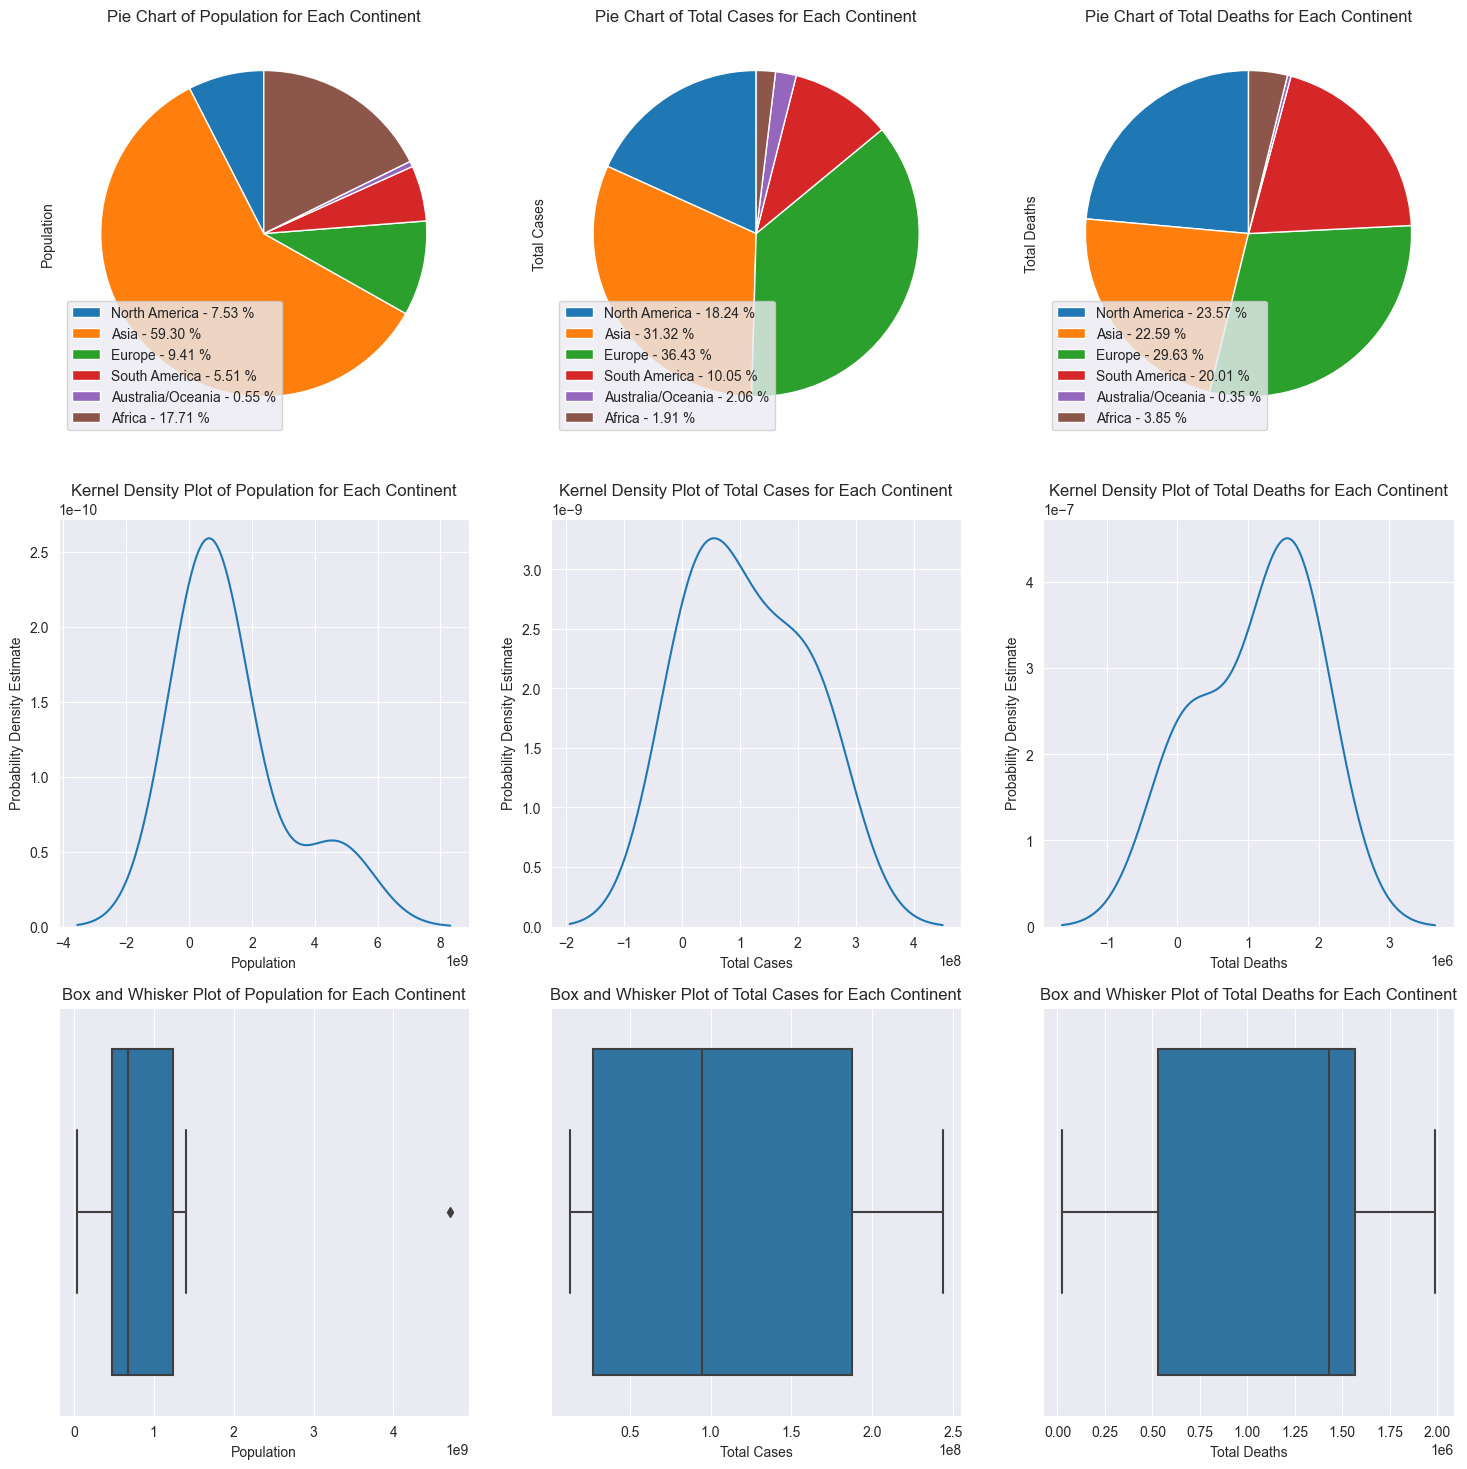

In [39]:
# Pie charts showing the share of population, total cases, and total deaths that each continent has
fig = plt.figure(figsize=(18, 18))  # Setting the figure size
plot_data = ["Population", "Total Cases", "Total Deaths"]  # List of the column titles we wish to plot
for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 1 + i, aspect="equal")  # Defining the axis and position of the chart
    PC = df.loc[:"Africa"].plot(kind="pie", y=plot_data[i], ax=ax, startangle=90, shadow=False, labels=None)  # Plotting the desired data
    x = np.char.array(new_continent_list[:-1])  # Creating an array of continent names for the legend
    y = df[plot_data[i]].head(6)  # Creating an array of continent data for the legend
    percent = 100.*y/y.sum()  # Calculating the percentage for each continent
    label = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]  # Formattingg the x and y data into a string
    plt.legend(label)  # Defining the legend
    PC.set_title(f"Pie Chart of {plot_data[i]} for Each Continent")

for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 4 + i)  # Defining the axis and position of the chart
    KDE = sns.kdeplot(data=df.loc[:"Africa"][plot_data[i]])
    KDE.set_title(f"Kernel Density Plot of {plot_data[i]} for Each Continent")
    KDE.set_ylabel("Probability Density Estimate")
    KDE.set_xlabel(plot_data[i])

for i in range(3):
    ax = plt.subplot(3, 3, 7 + i)
    #BWP = sns.boxplot(data=df.loc[:"Africa"][plot_data[i]])
    BWP = sns.boxplot(x=df.loc[:"Africa"][plot_data[i]])
    BWP.set_xlabel(plot_data[i])
    BWP.set_title(f"Box and Whisker Plot of {plot_data[i]} for Each Continent")

plt.show()  # Showing the figure

## Steps taken:
Firstly I defined the the data I wanted to visualise by putting the column titles into a list for iteration. Then, for each column in the list, I plot a pie chart for all rows in the countries column up until "Africa" to get a visualisation of some statics from the continents. Some of the labels and %s on the chart were overlapping, so i turned labels off and created two arrays of data, x=continent name and y=numeric data, that were then used to create a legend that included the same % data that was originally displayed on the charts themselves. Next, the same data were plot on kernel density estimate graphs and box and whisker plots to visualise the distribution and outliers of these data.

## Observations:
### Pie Charts:
These show that Asia and Africa have a much lower proportion of total cases/deaths when the size of their population is considered. Europe in particular holds a massive proportion of total cases, over three times its proportion of population, before slightly decreasing in its share of total deaths. North America, on the other hand, sees its total deaths increase in proportion from their total cases and south america is similar.

### KDE and Box Plots:
These plots both paint a very cool picture. They show how mean for all of these variables gradually shifts its skew from positive, to neutral, to slight negative. This implies that there must be some countries within these continents that, despite their small population size compared to china/india etc, did a very poor job at reducing the spread of covid resulting in a struggling healthcare system and, therefore, an increased number of deaths (UK, USA, Italy were all constantly in the news throoughout covid for their high covid cases).


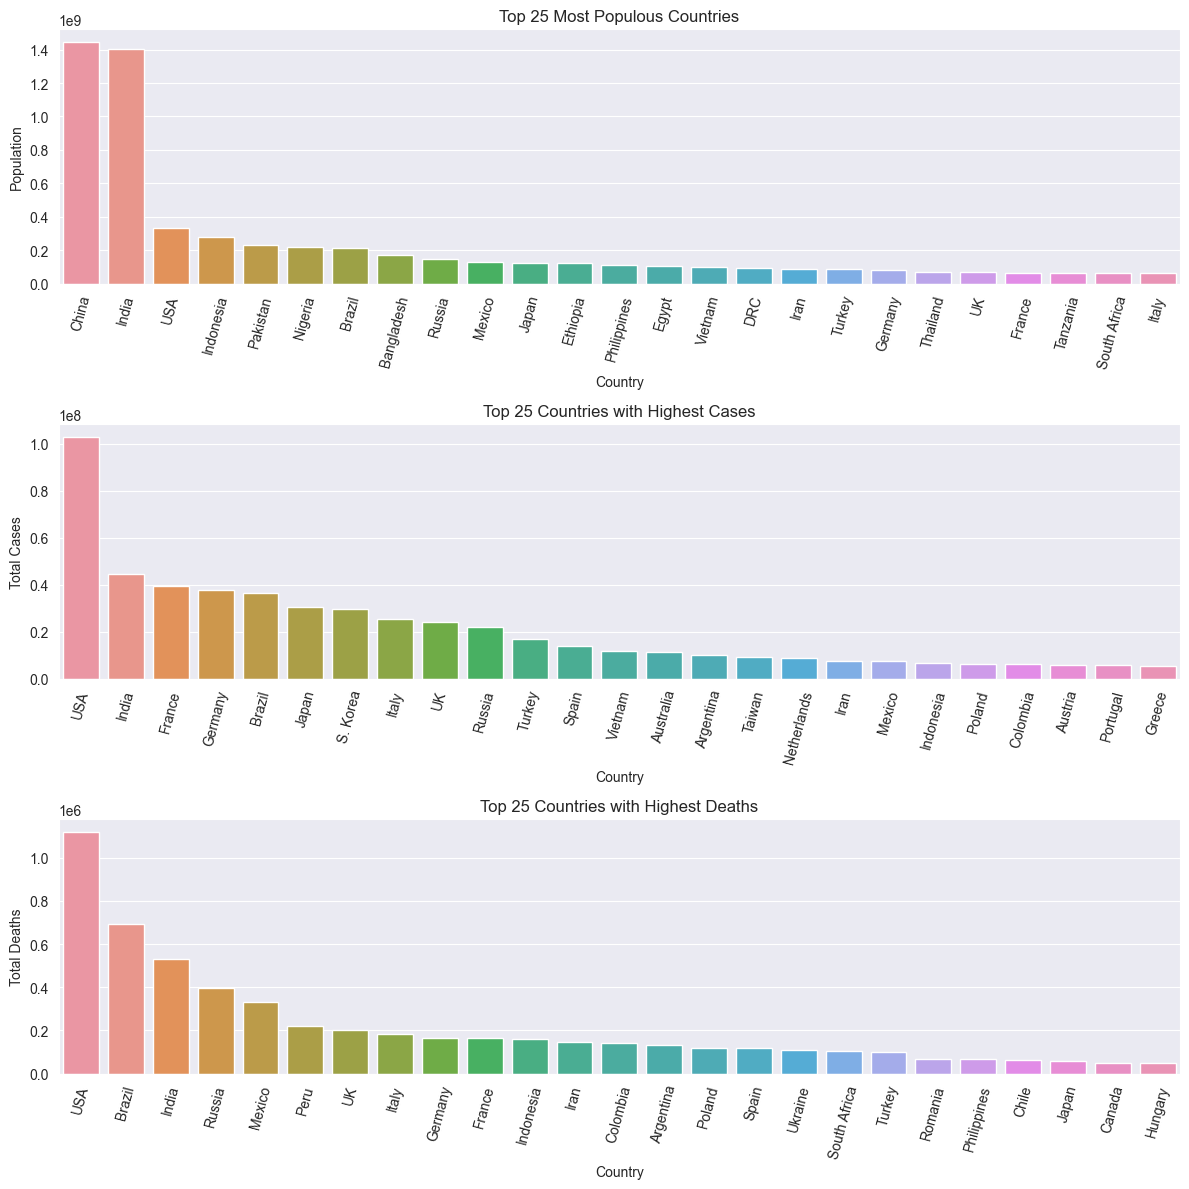

In [40]:
top_countries_pop = df.loc["USA":]["Population"].sort_values(ascending=False).head(25)  # Top 25 most populus countries on this dataset
top_countries_cases = df.loc["USA":]["Total Cases"].sort_values(ascending=False).head(25)  # Top 25 highest case countries on this dataset
top_countries_deaths = df.loc["USA":]["Total Deaths"].sort_values(ascending=False).head(25)  # Top 25 highest death countries on this dataset

fig = plt.figure(figsize=(12, 12))

ax = plt.subplot(3, 1, 1)
plt.xticks(rotation=75)
plt.title("Top 25 Most Populous Countries")
sns.barplot(x=top_countries_pop.index, y=top_countries_pop);

ax = plt.subplot(3, 1, 2)
plt.xticks(rotation=75)
plt.title("Top 25 Countries with Highest Cases")
sns.barplot(x=top_countries_cases.index, y=top_countries_cases);

ax = plt.subplot(3, 1, 3)
plt.xticks(rotation=75)
plt.title("Top 25 Countries with Highest Deaths")
sns.barplot(x=top_countries_deaths.index, y=top_countries_deaths);

fig.tight_layout()  # better spacing
plt.show()

## Steps taken:
Once I had finished observing the continent data, I wanted to have a look at the same data but for individual countries. There are far too many to look at all countries on a pie chart, so I decided to look at the top 25 in each catagory to visualise on a barchart. First i defined the data I wanted to use in each column and ensured they were sorted in descending order.

## Observations:
Like was suggested in the previous section, there are some smaller countires that dealt with covid much worse. China and India have the largest population by far, but india remains in second/third place for these stats by quite a large margin due to the USA. China is nowhere to be seen, so I am thinking that its total cases data might be slightly innacurate. There are also, as predicted, countries like the UK, Italy, and France that jump way up the "leaderboard" for top 25 cases and deaths.


In [41]:
# Due the poisitive skew of these distributions it is worth calculating the central tendency of the distributions
df2 = pd.DataFrame()
df2["Mean"] = df.loc["USA":].mean(numeric_only=True)
df2["Median"] = df.loc["USA":].median(numeric_only=True)

# Displaying descriptive statistics for Continents
df.loc[:"Africa"].describe()



,GDP (USD million),Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People,Total Recovered / 1M People
count,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1.404993e+07,1.324156e+09,1.114690e+08,1.119062e+06,1.149243e+09,1.066740e+08,3.675940e+06,8107.666667,175562.957032,1571.443824,1.513645e+06,25.083529,1909.754246,2.972930,3690.205767,170301.307440
std,1.337399e+07,1.718458e+09,9.842500e+07,7.900766e+05,1.205022e+09,9.441210e+07,4.917705e+06,7235.116935,133158.599132,1350.728619,1.395956e+06,42.418979,2056.196288,4.871985,2251.447870,130732.086874
min,1.668576e+06,4.347041e+07,1.274629e+07,2.377000e+04,8.845918e+07,1.204350e+07,2.586390e+05,134.000000,9060.944446,183.670094,7.811318e+04,3.068256,325.770705,0.266052,315.923025,8561.351328
25%,2.533181e+06,4.778061e+08,2.711389e+07,5.296720e+05,1.427312e+08,2.629806e+07,6.014368e+05,2483.250000,71721.278089,378.199503,5.126362e+05,3.595677,376.346153,0.470212,2541.536101,67988.408638
50%,1.194230e+07,6.728424e+08,9.460630e+07,1.430303e+06,7.663769e+08,9.077612e+07,2.213692e+06,8799.500000,178755.951762,1596.167093,1.293082e+06,5.708089,1103.394839,1.152763,3651.530202,171612.127413
75%,2.326063e+07,1.241933e+09,1.876020e+08,1.566058e+06,2.088816e+09,1.752056e+08,3.585157e+06,10285.750000,288321.808529,2657.145251,2.128101e+06,18.498092,2786.416703,1.954218,5584.300378,281257.452883
max,3.231620e+07,4.711357e+09,2.436381e+08,1.989228e+06,2.809767e+09,2.382939e+08,1.326329e+07,19754.000000,325918.079905,3069.643724,3.758666e+06,110.363771,5444.544513,12.801937,6122.156004,318769.174737


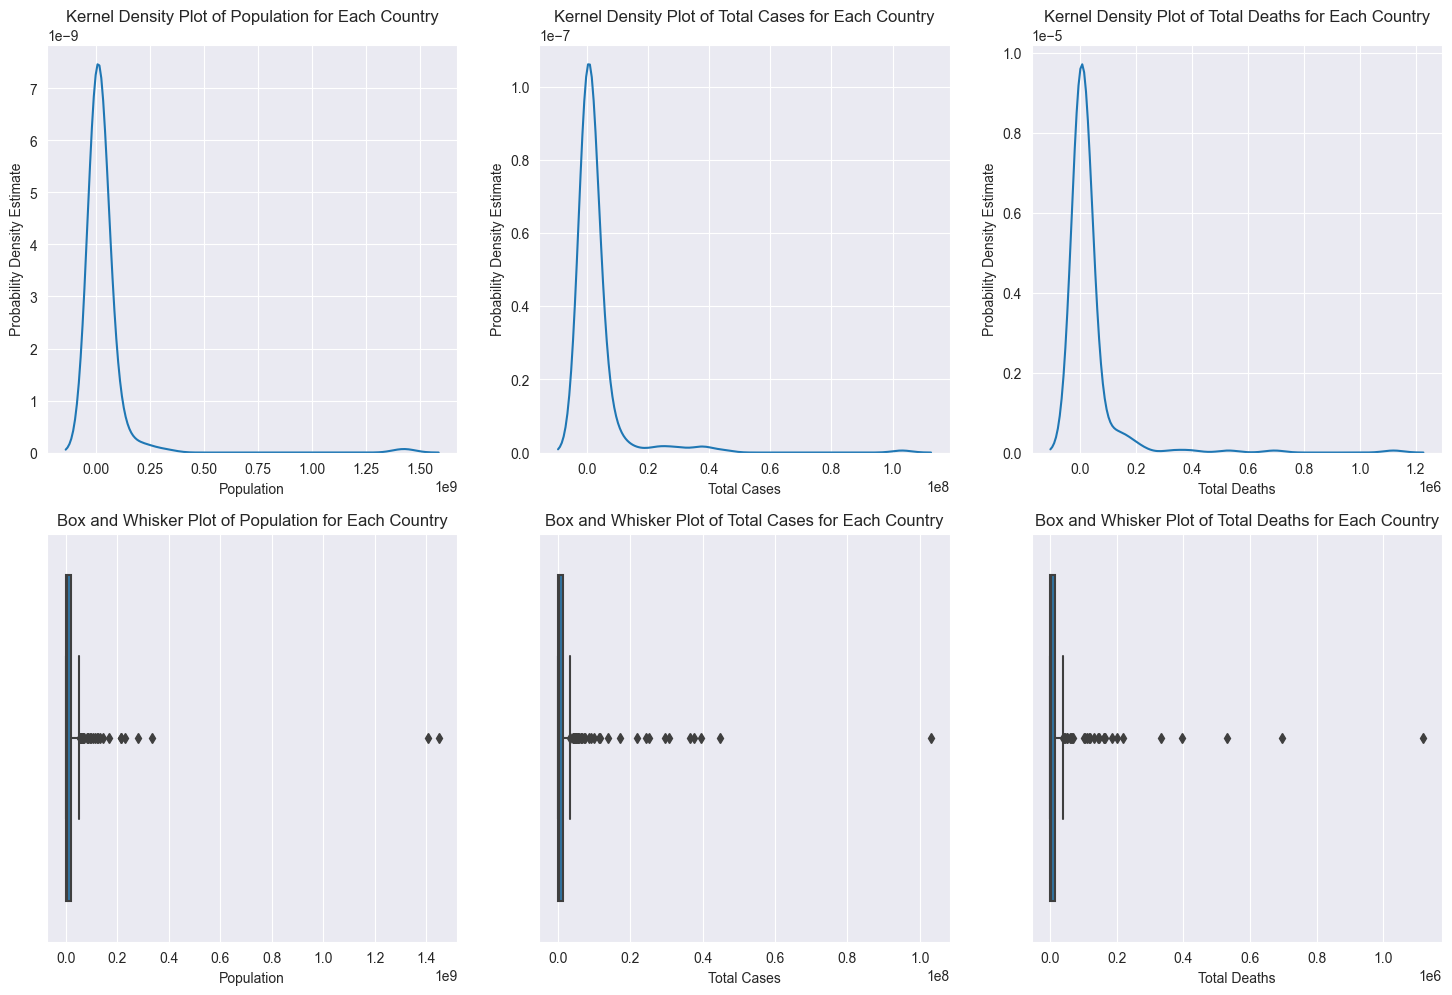

In [42]:
# Country Data Distributions
fig = plt.figure(figsize=(18, 18))  # Setting the figure size
plot_data = ["Population", "Total Cases", "Total Deaths"]  # List of the column titles we wish to plot
for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 4 + i)  # Defining the axis and position of the chart
    KDE = sns.kdeplot(data=df.loc["USA":][plot_data[i]])
    KDE.set_title(f"Kernel Density Plot of {plot_data[i]} for Each Country")
    KDE.set_ylabel("Probability Density Estimate")
    KDE.set_xlabel(plot_data[i])

for i in range(3):
    ax = plt.subplot(3, 3, 7 + i)
    BWP = sns.boxplot(x=df.loc["USA":][plot_data[i]])
    BWP.set_xlabel(plot_data[i])
    BWP.set_title(f"Box and Whisker Plot of {plot_data[i]} for Each Country")

plt.show()

## Steps taken:
The exact same steps were taken for the country data as for the continent data. The only difference was the changing of .loc[:"Africa"] to .loc["USA":].

## Observations:
Due to the amount of territories and small countries (vatican city) on this list, the mean for all this data is massively positively skewed with many outliers.

Pearsons correlation: 0.985
Pearsons correlation: 0.991


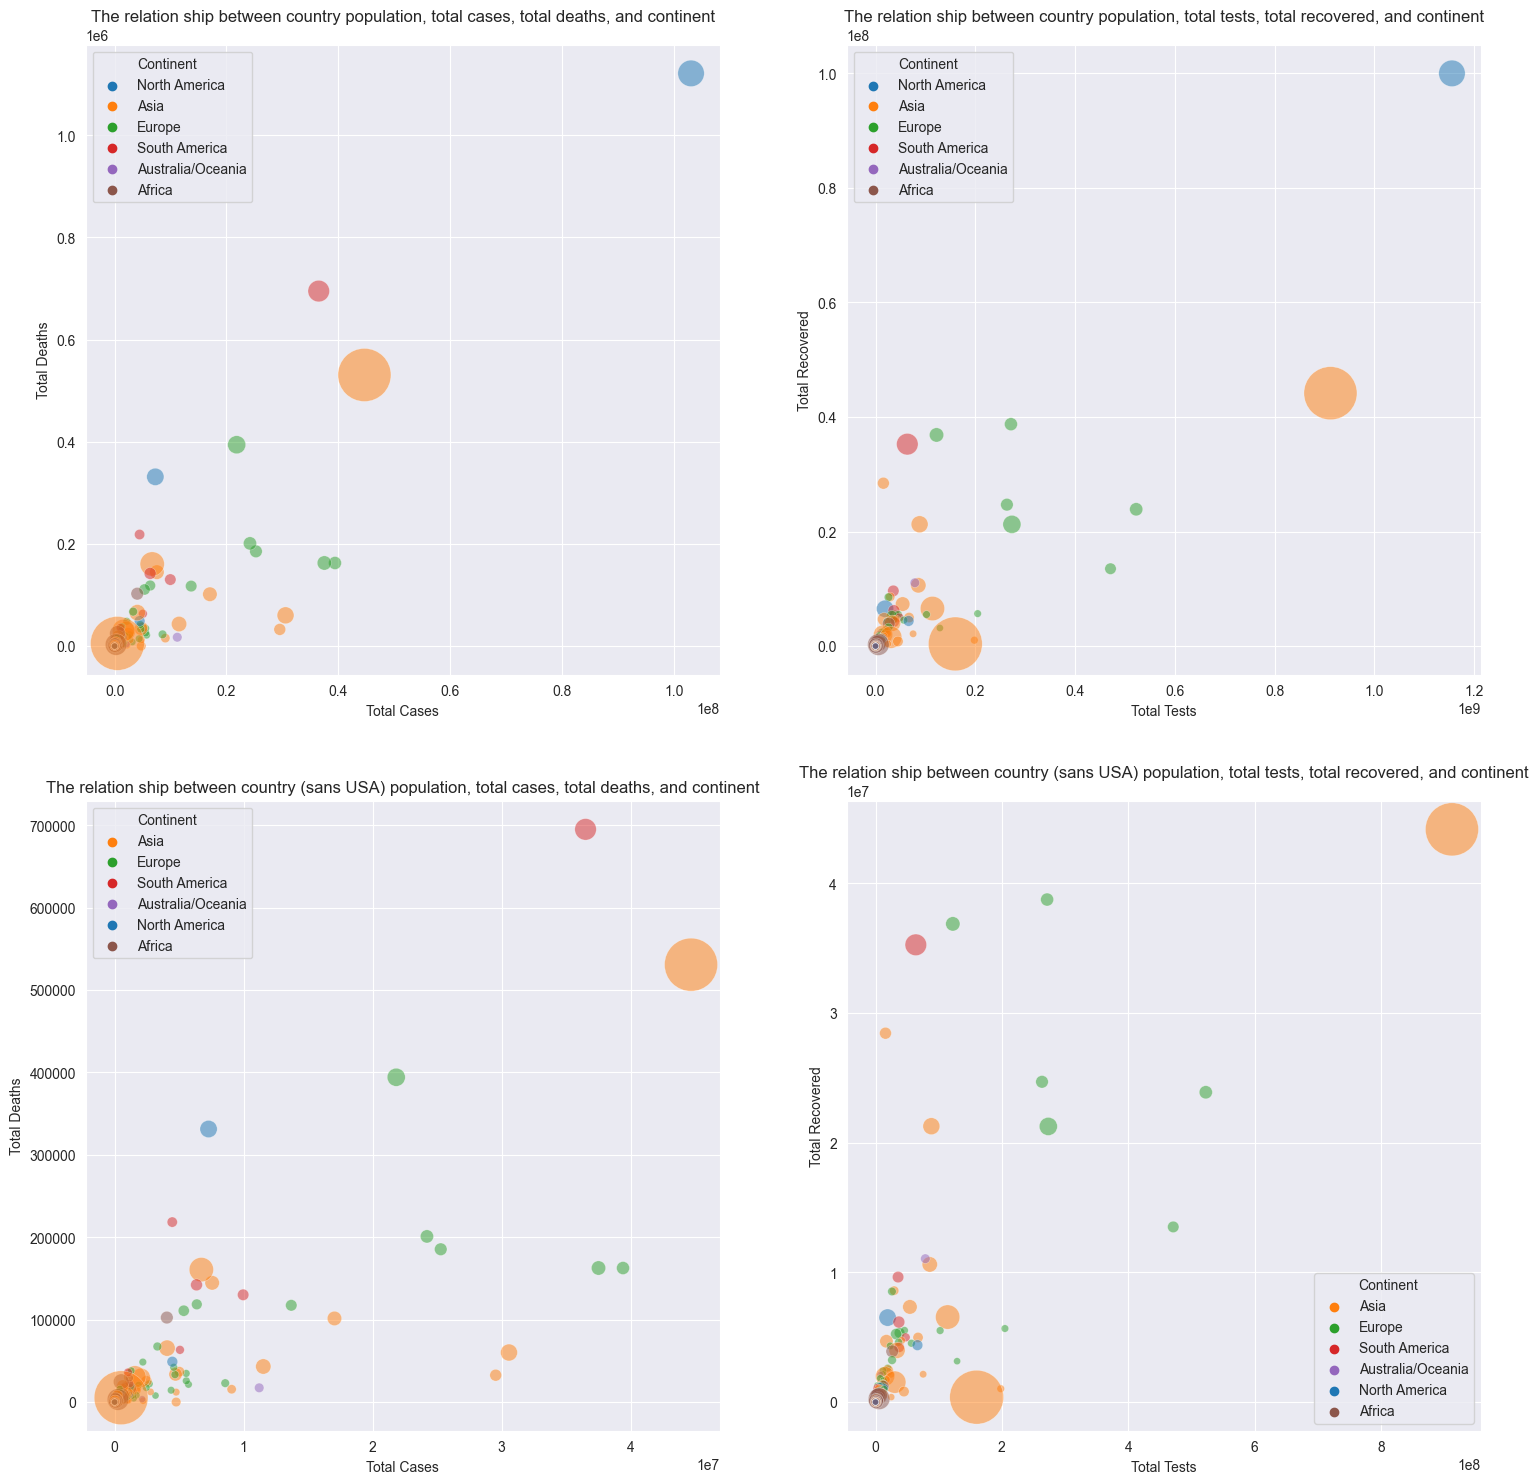

In [43]:
# Relationship between country population, total cases, total deaths, and continent
fig = plt.figure(figsize=(18, 18))

ax1 = plt.subplot(2, 2, 1)
BP1 = sns.scatterplot(data=df.loc["USA":], x="Total Cases", y="Total Deaths", size="Population", hue="Continent", palette=colour_dict,
                      sizes=(20,1500), alpha=0.5, legend=True)
h,l = BP1.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7])
BP1.set_title("The relation ship between country population, total cases, total deaths, and continent")

# Relationship between country population, total tests, total recovered, and continent
ax2 = plt.subplot(2, 2, 2)
BP2 = sns.scatterplot(data=df.loc["USA":], x="Total Tests", y="Total Recovered", size="Population", hue="Continent", palette=colour_dict,
                      sizes=(20,1500), alpha=0.5, legend=True)
h,l = BP2.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7])
BP2.set_title("The relation ship between country population, total tests, total recovered, and continent")

# Relationship between country (NO AMERICA) population, total tests, total deaths, and continent
ax3 = plt.subplot(2, 2, 3)
BP3 = sns.scatterplot(data=df.loc["India":], x="Total Cases", y="Total Deaths", size="Population", hue="Continent", palette=colour_dict,
                      sizes=(20,1500), alpha=0.5, legend=True)
h,l = BP3.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7])
BP3.set_title("The relation ship between country (sans USA) population, total cases, total deaths, and continent")

# Relationship between country (NO AMERICA) population, total tests, total recovered, and continent
ax4 = plt.subplot(2, 2, 4)
BP4 = sns.scatterplot(data=df.loc["India":], x="Total Tests", y="Total Recovered", size="Population", hue="Continent", palette=colour_dict,
                      sizes=(20,1500), alpha=0.5, legend=True)
h,l = BP4.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7])
BP4.set_title("The relation ship between country (sans USA) population, total tests, total recovered, and continent")

s_df = df.dropna()
data1 = s_df["Total Cases"]
data2 = s_df["Total Deaths"]
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

data1 = s_df["Total Recovered"]
data2 = s_df["Total Tests"]
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

plt.show()

## Steps taken:
Previously in the notebook, a colour dictionary was created to ensure the consistancy of colours for continents when ploting graphs like these. For each bubble plot the portion of the datafram required, i.e. ["USA":], was specified. The same colour pallete, hue, and bubble size (="Population") were used for all bubble plots with the x and y axes being the only changes between plots. For the second 2 plots, the USA was removed just to get a better look at the rest of the data.

## Observations:
There looks as though there is some correlation in all the graphs, though it is not particularly strong. I was expecting to see a lot of the larger bubbles closer to the upper right as a larger population implies more cases, more tests, and more deaths but this was not the case. The pearsosns correlation for both of these charts was ~0.99 for both, indication a very high positive correlation.

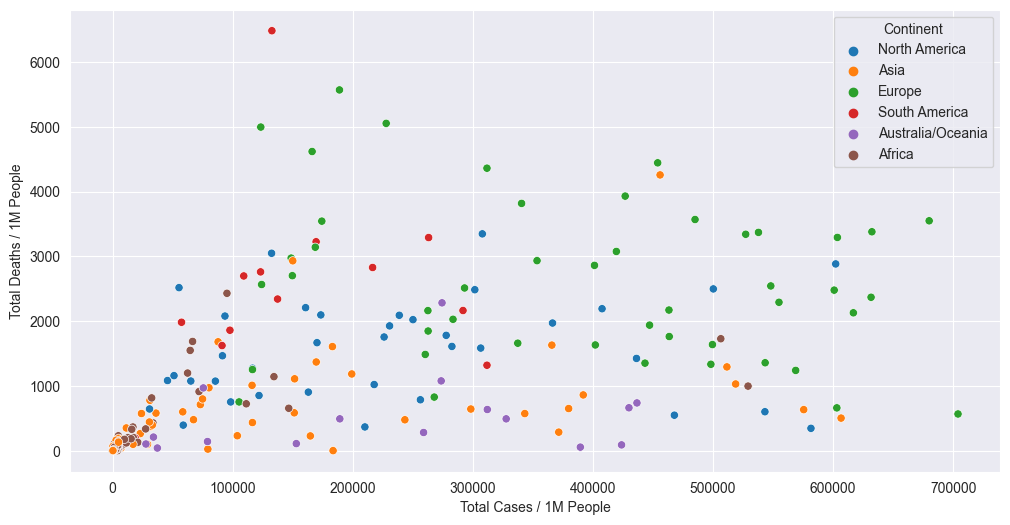

Pearsons correlation: 0.506


In [44]:
fig = plt.figure(figsize=(12, 6))
SP = sns.scatterplot(data=df.loc["USA":], x="Total Cases / 1M People", y="Total Deaths / 1M People", hue="Continent", palette=colour_dict, legend=True)
plt.show()

data1 = s_df["Total Cases / 1M People"]
data2 = s_df["Total Deaths / 1M People"]
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)  # 0.5 -> A moderate positive relationship

## Steps taken:
The steps taken for this were near identical as for the bubble plots but with different data, without the bubble size. These graphs were plot to see whether the relationship between deaths/cases and recovered/tests was the same when it was for "What proportion of the country compared to other countries" as "What proportion of the world compared to other countries".

## Observations:
The pearsons correlation for this data was 0.511, which is much less than the bubble plots but still shows a moderate positve relationship.

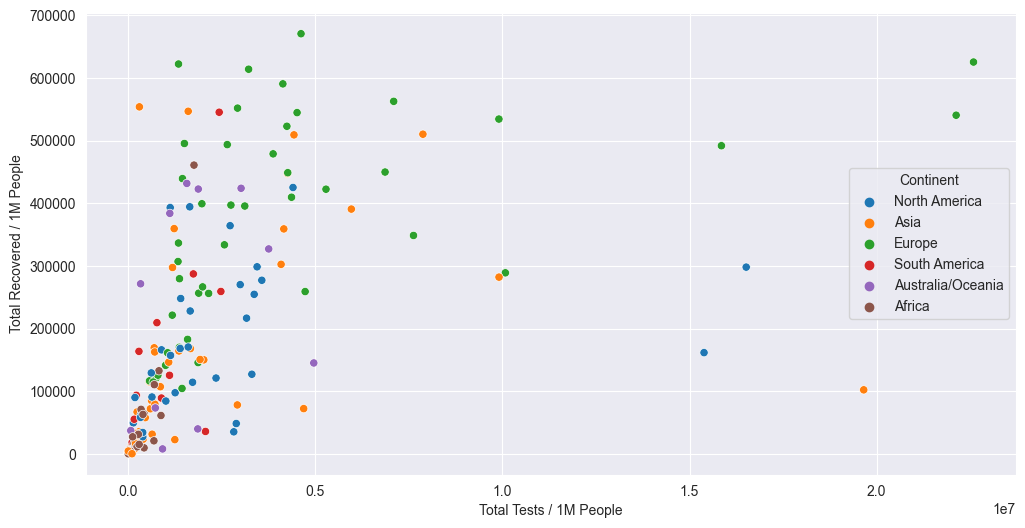

Pearsons correlation: 0.614


In [45]:
fig = plt.figure(figsize=(12, 6))
SP = sns.scatterplot(data=df.loc["USA":], x="Total Tests / 1M People", y="Total Recovered / 1M People", hue="Continent", palette=colour_dict, legend=True)
plt.show()



data1 = s_df["Total Tests / 1M People"]
data2 = s_df["Total Recovered / 1M People"]
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)  # 0.6 -> A moderate positive relationship

## Steps taken:
The same as the previous scatter plot.

## Observations:
Pearsons correlation of 0.616 suggesting a stronger, but still moderate, positve correlation than the previous scatter plot

# Step 4a: What are the outlier countries for total cases? (10%)
## The process:
First I calculated the mean and standard deviaton for all countries (no continants) in the data frame. Next, I defined a boolean mask to applied to the whole data frame based on whether a country has a total case count such that total cases - mean > 2 * standard deviation to isolate the outliers. This mask was then applied to the dataframe to fetch their index (country name) to be added to a list for outputting.

In [46]:
# Calculate the mean and standard deviation of the column
mean_total_cases = df.loc["USA":, "Total Cases"].mean()
std_total_cases = df.loc["USA":, "Total Cases"].std()

# Creating a boolean mask for the outliers
mask = ((df.loc["USA":, "Total Cases"] - mean_total_cases).abs() > 2 * std_total_cases) #| (df.index.isin(new_continent_list))

# Getting the index of all the outlier values
case_outlier_countries_index = df.loc["USA":][mask].index

# Adding the index to a list of countries
case_outlier_countries = list(case_outlier_countries_index)
string = "The outlier countries for total Covid-19 cases are: " + ", ".join(map(str, case_outlier_countries))
print(string)


The outlier countries for total Covid-19 cases are: USA, India, France, Germany, Brazil, Japan, S. Korea, Italy, UK, Russia


It was shown that the outlier countries are USA, India, France, Germany, Brazil, Japan, S. Korea, Italy, UK, and Russia. It feels like China should be on here, the data set claims ~400k total cases for china while google suggests 1.9M. Google agrees with China total deaths however, so it is only the total cases data that is inaccurate. What is common about them: They are all members of the united nations, they are among the most populous countries in the world, they are all considered to be major econmic powers either as developed countries or emerging markets, and the majority of them are in Europe. Next I want to see what the outlier countries are for total deaths.

In [47]:
mean_total_deaths = df.loc["USA":, "Total Deaths"].mean()
std_total_deaths = df.loc["USA":, "Total Deaths"].std()

# Creating a boolean mask for the outliers
mask = ((df.loc["USA":, "Total Deaths"] - mean_total_deaths).abs() > 2 * std_total_deaths)

# Getting the index of all the outlier values
death_outlier_countries_index = df.loc["USA":][mask].index

# Adding the index to a list of countries
death_outlier_countries = list(death_outlier_countries_index)
string = "The outlier countries for total Covid-19 deaths are: " + ", ".join(map(str, death_outlier_countries))
print(string)

The outlier countries for total Covid-19 deaths are: USA, India, Brazil, Russia, Mexico


Of the 10 outlier countries in terms of cases, four of them make up the 5 outlier countries for total deaths which would suggest that they had high cases/deaths due to poor countermeasures. To see if this may be the case, I will perform the same check on the outlier countries for total tests. It coud be inferred that countries that ARE in the outliers for total cases and NOT in the outliers for total deaths did a better than avereage job at vaccinating/taking care of their covid cases as they managed to not produce an equally large number of deaths.

In [48]:
mean_total_tests = df.loc["USA":, "Total Tests"].mean()
std_total_tests = df.loc["USA":, "Total Tests"].std()

# Creating a boolean mask for the outliers
mask = ((df.loc["USA":, "Total Tests"] - mean_total_tests).abs() > 2 * std_total_tests)

# Getting the index of all the outlier values
test_outlier_countries_index = df.loc["USA":][mask].index

# Adding the index to a list of countries
test_outlier_countries = list(test_outlier_countries_index)
string = "The outlier countries for total Covid-19 tests are: " + ", ".join(map(str, test_outlier_countries))
print(string)

The outlier countries for total Covid-19 tests are: USA, India, France, UK, Russia, Spain


The countries (all but spain) in the outliers for total tests that are also in the total cases outlier set, this means that they simply kept up with their need for covid testing. Spain on the other hand did seemingly did excess testing, which may be what helped keep it from being an outlier in total cases by catching them early. Next I will visualise these three sets and where they overlap.



These are the countries that are ONLY in the Tests set (Red section):
    Spain
These are the countries that are ONLY in the Deaths set (Green section):
    Mexico
These are the countries that are ONLY in the Cases set (Blue section):
    Italy
    Germany
    S. Korea
    Japan
These are the countries that are ONLY in the overlap between all three sets (brown section):
    USA
    India
    Russia
These are the countries that are ONLY in the overlap between Tests and Cases (Magenta section):
    UK
    France
These are the countries that are ONLY in the overlap between Deaths and Cases (Cyan section):
    Brazil


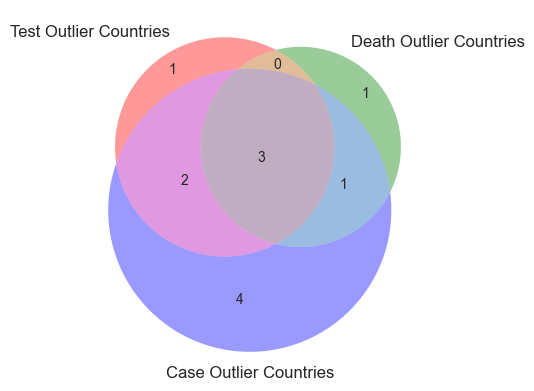

In [49]:
venn_diagram = venn3([set(test_outlier_countries), set(death_outlier_countries), set(case_outlier_countries)],
                     ("Test Outlier Countries", "Death Outlier Countries", "Case Outlier Countries"))

# Get the items only in test outlier
test_only_items = set(test_outlier_countries) - set(case_outlier_countries) - set(death_outlier_countries)
print("These are the countries that are ONLY in the Tests set (Red section):")
for i in test_only_items:
    print(f"    {i}")

# Get the items only in death outlier
death_only_items = set(death_outlier_countries) - set(case_outlier_countries) - set(test_outlier_countries)
print("These are the countries that are ONLY in the Deaths set (Green section):")
for i in death_only_items:
    print(f"    {i}")

# Get the items only in death outlier
case_only_items = set(case_outlier_countries) - set(death_outlier_countries) - set(test_outlier_countries)
print("These are the countries that are ONLY in the Cases set (Blue section):")
for i in case_only_items:
    print(f"    {i}")

# Get the items in the intersection of all three sets
all_items = set(test_outlier_countries) & set(death_outlier_countries) & set(case_outlier_countries)
print("These are the countries that are ONLY in the overlap between all three sets (brown section):")
for i in all_items:
    print(f"    {i}")

# Get the items in the intersection of sets test and case and not death
test_case_items = set(test_outlier_countries) & set(case_outlier_countries)
# Remove the items that are also in set C
test_case_items -= set(death_outlier_countries)
print("These are the countries that are ONLY in the overlap between Tests and Cases (Magenta section):")
for i in test_case_items:
    print(f"    {i}")

# Get the items in the intersection of sets death and case and not test
death_case_items = set(death_outlier_countries) & set(case_outlier_countries)
# Remove the items that are also in set B
death_case_items -= set(test_outlier_countries)
print("These are the countries that are ONLY in the overlap between Deaths and Cases (Cyan section):")
for i in death_case_items:
    print(f"    {i}")


plt.show()

Red Section Only: Spain. Did more tests relative to cases/deaths than any other country. May be the reason they kept cases/deaths low.
Green Section Only: Mexico. More deaths relative to cases/tests than any other country. May be caused by poor/underprepped hospitals/cant afford loads of testing.
Blue Section Only: Germany, S. Korea, Italy, Japan. More cases relative to deaths/tests than any other country. These may not have had particularly strict covid regulations (lockdowns etc) compared to some places.
Brown Section Only: India, USA, Russia. Outlier in all three statistics, could mean a few things depending on the extent to which certain statistics are outliers.
Magenta Section Only: UK, France. More Tests and Cases relative to other countries. This may be because they had the facilities to to extensive testing (sush as test and trace scheme) which uncovered many cases in teh country resulting in people getting the care they needed to prevent deaths. Both countries have some really dense urban areas also where covid cases will have spread incredibly quickly.
Cyan Section Only: Brazil. More deaths and cases relative to any other country. A country that could be called "second world", not enough money to roll out large scale testing (test and trace etc) and healthcare system not well funded enough to cope with the resultant raised covid levels.



# Step 4b: What relationship between a country's GDP per capita and the number of Covid-19 deaths per 1,000,000 population?

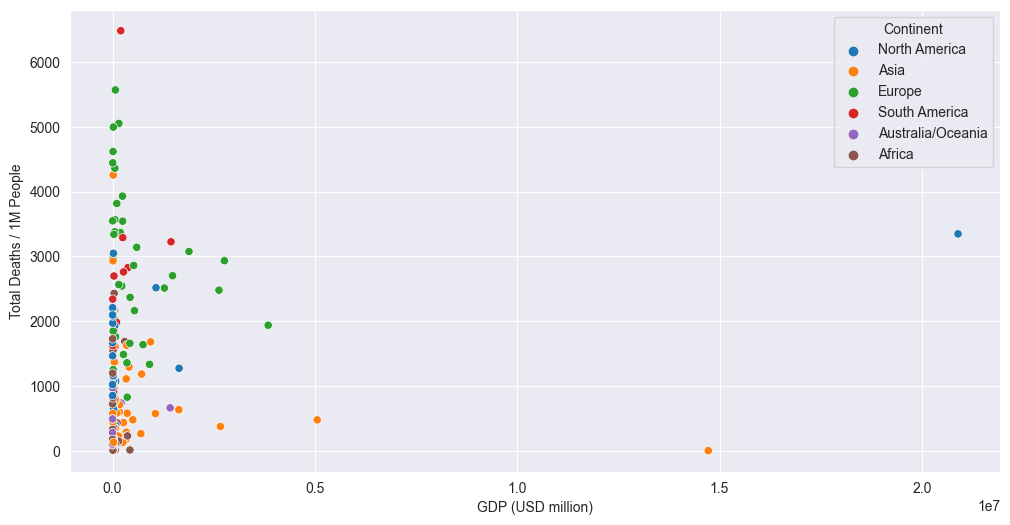

Pearsons correlation: -0.019


In [50]:
fig = plt.figure(figsize=(12, 6))
SP = sns.scatterplot(data=df.loc["USA":], x="GDP (USD million)", y="Total Deaths / 1M People", hue="Continent", palette=colour_dict, legend=True)
plt.show()

s_df = df.dropna()
data1 = s_df["Total Deaths / 1M People"]
data2 = s_df["GDP (USD million)"]
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)



The pearsons correlation value of -0.019 suggests that there is no correlation whatsoever between a countries GDP and the number of deaths they experienced per one million people. This will largely be due to countries like China and USA with such large GDP's compared to the rest of the world

Next i am going to plot this graph for the countries without China and USA to see if there is an improved correlation.

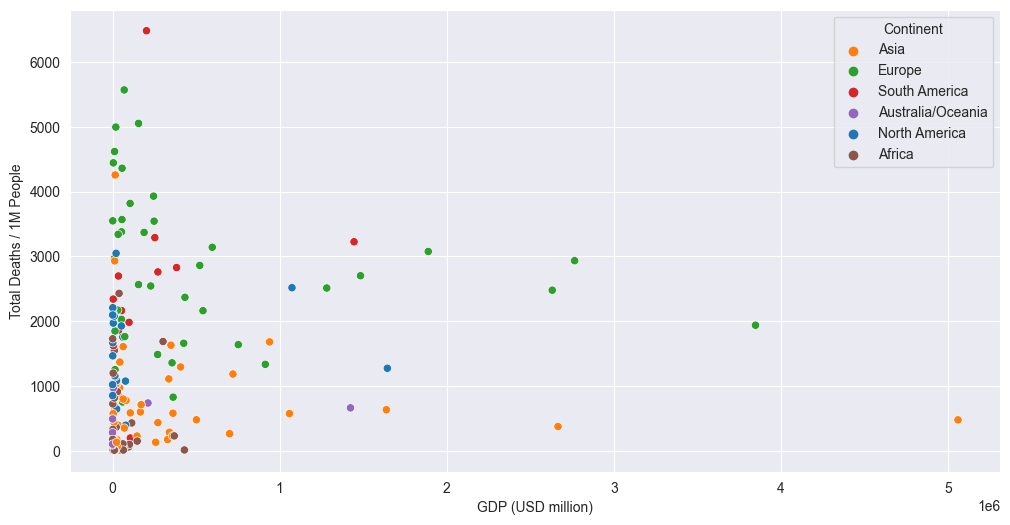

Pearsons correlation: 0.047


,Continent,GDP (USD million),Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People,Total Recovered / 1M People,Mortality Rate (%)
Country,,,,,,,,,,,,,,,,,,
India,Asia,2664749.0,1.406632e+09,44681170.0,530721.0,911951216.0,44147002.0,3447.0,698.0,31764.652813,377.299169,6.483226e+05,31.481534,2650.416652,1.542442,2.450535,31384.903109,1.187796
France,Europe,2630318.0,6.558452e+07,39407727.0,162643.0,271490188.0,38737262.0,507822.0,869.0,600869.354563,2479.899296,4.139547e+06,1.664255,403.242181,0.241572,7743.016423,590646.438844,0.412719
Germany,Europe,3846414.0,8.388360e+07,37509539.0,162688.0,122332384.0,36861300.0,485551.0,1406.0,447161.790727,1939.449520,1.458359e+06,2.236327,515.610223,0.685702,5788.390378,439433.950829,0.433724
Brazil,South America,1444733.0,2.153536e+08,36504006.0,694909.0,63776166.0,35247755.0,561342.0,8318.0,169507.299560,3226.827982,2.961463e+05,5.899451,309.901862,3.376710,2606.606150,163673.865427,1.903651
Japan,Asia,5057759.0,1.255848e+08,30568877.0,60158.0,88389228.0,21265232.0,9243487.0,648.0,243412.162541,479.022794,7.038209e+05,4.108258,2087.583331,1.420816,73603.526884,169329.612863,0.196795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Montserrat,North America,NaN,4.965000e+03,1403.0,8.0,17762.0,1376.0,19.0,NaN,282578.046324,1611.278953,3.577442e+06,3.538845,620.625000,0.279529,3826.787513,277139.979859,0.570207
Niue,Australia/Oceania,NaN,1.622000e+03,644.0,NaN,NaN,495.0,149.0,NaN,397040.690506,NaN,NaN,2.518634,NaN,NaN,91861.898890,305178.791615,NaN
Vatican City,Europe,NaN,7.990000e+02,29.0,NaN,NaN,29.0,0.0,NaN,36295.369212,NaN,NaN,27.551724,NaN,NaN,0.000000,36295.369212,NaN


In [59]:
df["Mortality Rate (%)"] = df["Total Deaths"] * 100 / df["Total Cases"]  # For Later
df_copy = df.loc["India":].drop(["China"])  # Skips to india (i.e. removes continents and USA) and then removes China

fig = plt.figure(figsize=(12, 6))
SP = sns.scatterplot(data=df_copy, x="GDP (USD million)", y="Total Deaths / 1M People", hue="Continent", palette=colour_dict, legend=True)
plt.show()

s_df_copy = df_copy.dropna()
data1 = s_df_copy["Total Deaths / 1M People"]
data2 = s_df_copy["GDP (USD million)"]
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

df_copy

There is improved pearsons correlation, however due to the shear number of low GDP countries and territories it cannot be said there is any correlation,

Next I am going to plot the Mortality rate (%) against GDP to see if there is more correlation there.

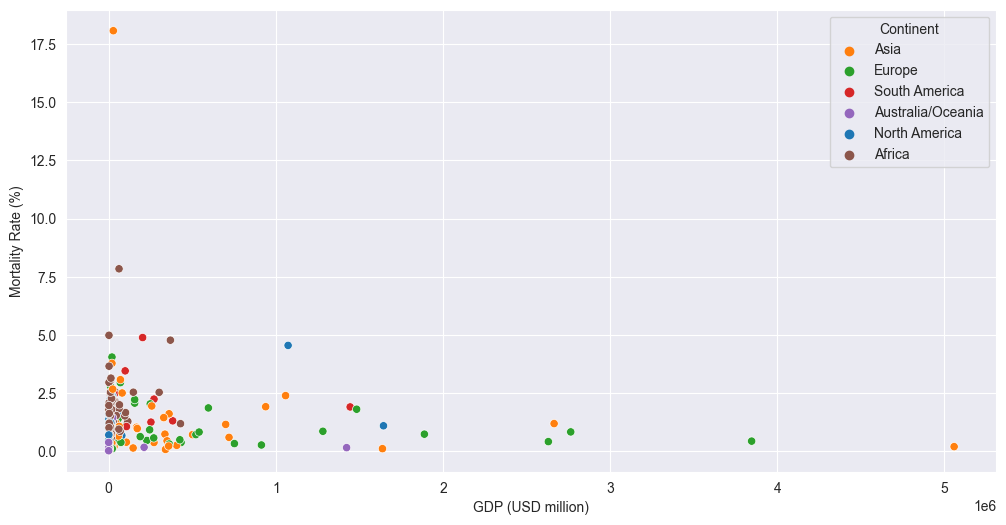

Pearsons correlation: -0.111


In [60]:
fig = plt.figure(figsize=(12, 6))
SP = sns.scatterplot(data=df_copy, x="GDP (USD million)", y="Mortality Rate (%)", hue="Continent", palette=colour_dict, legend=True)
plt.show()

data1 = s_df_copy["Mortality Rate (%)"]
data2 = s_df_copy["GDP (USD million)"]
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

There is also effectively no correlation between a countries mortality rate and their GDP. Once again due to the shear number of territories and low GDP countries.

Next, I am going to calculate the mortality rate for the top 25 highest GDP countries and apply some statistical testing to determine whether their population mean is different to the global population mean, which would suggest that an increase in GDP means a change in mortality rate on the whole.

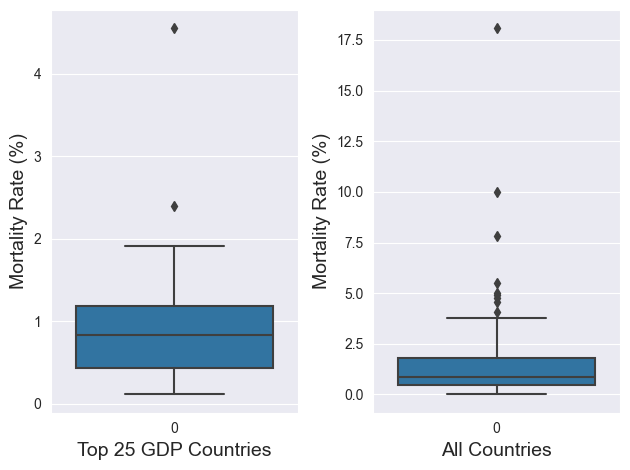

T-test: (pvalue= 0.46147307432987916 > 0.05). Can't reject that these have identical mean


In [83]:
top_countries_GDP = df.loc["USA":].sort_values(by="GDP (USD million)", ascending=False).head(25)  # Top 25 highest GDP countries on this dataset
top_GDP_mortality = top_countries_GDP["Mortality Rate (%)"].astype(float, errors="ignore")
top_GDP_mortality = top_GDP_mortality.dropna()
all_countries_mortality = df.loc["USA":]["Mortality Rate (%)"].astype(float, errors="ignore")
all_countries_mortality = all_countries_mortality.dropna()

ax1 = plt.subplot(1, 2, 1)
BP1 = sns.boxplot(data=top_GDP_mortality)
BP1.set_ylabel("Mortality Rate (%)", fontsize=14)
BP1.set_xlabel("Top 25 GDP Countries", fontsize=14)

ax2 = plt.subplot(1, 2, 2)
BP2 = sns.boxplot(data=all_countries_mortality)
BP2.set_ylabel("Mortality Rate (%)", fontsize=14)
BP2.set_xlabel("All Countries", fontsize=14)

plt.tight_layout()
plt.show()

statistic, pvalue = stats.ttest_ind(top_GDP_mortality, all_countries_mortality)
stmnt1 = f"T-test: (pvalue= {pvalue} < 0.05). Reject that these samples have identical mean"  # Different
stmnt2 = f"T-test: (pvalue= {pvalue} > 0.05). Can't reject that these have identical mean"  # Same
print(stmnt1) if pvalue < 0.05 else print(stmnt2)

The t-test gave results suggesting the null hypothesis that both samples have different population means cannot be rejected at the 5% significance level. Therefore, it does not seem like GDP had an impact on the mortality rate of covid BUT there are some countries with very low GDP and very high mortality rates.

# Step 4c: What is the relationship between a countries GDP per capita and the number of Covid-19 recoveries?

Step 5: Summary and Conclusion (5%)

Write summary/conc in here